# Descripción del proyecto

La compañía ##### #### Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Se construyeron modelos de machine learning utilizando series temporales para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48 a petición del cliente.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv` el cual contiene 26496 filas y dos columnas. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### Importar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
import optuna
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta


c:\Users\juano\anaconda3\envs\EnsamblesCatBoost\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Leer datos

In [2]:
df = pd.read_csv(r'C:\Users\juano\OneDrive\Escritorio\Juan\Tripleten\Sprint 13 Series temporales\Proyecto\taxi.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.iloc[200:250]

,datetime,num_orders
200,2018-03-02 09:20:00,9
201,2018-03-02 09:30:00,7
202,2018-03-02 09:40:00,11
203,2018-03-02 09:50:00,5
204,2018-03-02 10:00:00,6
205,2018-03-02 10:10:00,7
206,2018-03-02 10:20:00,10
207,2018-03-02 10:30:00,18
208,2018-03-02 10:40:00,8
209,2018-03-02 10:50:00,5


El dataframe muestra dos columnas una almacenando variables de tipo 'object' y otra 'int'. El dataframe consta de 26496 filas y dos columnas. No se observa la presencia de valores asuentes típicos. Se ve de manifiesto que el formato de la columna 'datetime es año-mes-día hora(24hrs):min:seg'

### Análisis Exploratorio de Datos (EDA)

In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Se observa que los datos tienen una media de 14.070, con una desviación estándar de 9.211 en un intervalo de 0.000 a 119.

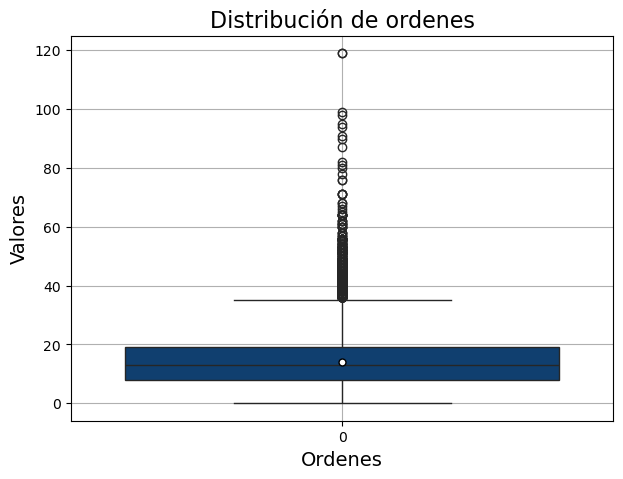

In [6]:
#Gráfico de caja y bigotes
fig = plt.figure(figsize =(7, 5))
df_box = df.drop(['datetime'], axis=1)
sns.boxplot(df_box.values, showmeans=True, meanprops={'marker':'o',
                                                     'markerfacecolor':'white',
                                                     'markersize':'5',
                                                     'markeredgecolor':'black'},
           palette='ocean_r'
           )

plt.title('Distribución de ordenes', fontsize=16)
plt.xlabel('Ordenes', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.grid(True) 

plt.show()

Se observó que la media (señalada en blanco) y la mediana (Q2) en el gráfico de caja y bigotes se encuentran cerca, con una sesgo de los datos hacia la derecha, al observar el desplazamiento de la mediana en el espacio intercuartílico derecho con respecto a la mediana. Por otra parte, se obsrva que existen multiples valores outliners que superiores al límete superior.

## Análisis

El tipo de problema a solucionar requiere abordarlo como una serie temporal, en el cual el número de ordenes de taxi será la variable a considerar. Se debe remuestrear los datos de la columna 'num_orders', de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora. inicialmente se  convirtió los datos a un formato conveniente, estableciendo el índice de la tabla igual a la columna 'datetime' conservando el orden cronólogico de los datos.

### Cambio de formato a datetime e indexación

In [7]:
#Conversión de columna 'datetime' de object al tipo datetime

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [8]:
#Reindexación del dataframe con la columna 'datetime'

df = df.set_index('datetime')
df.info()
print()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
#Comprobar el orden cronológico del índice del dataframe

print(df.index.is_monotonic_increasing)

True


### Eliminación de outliners

In [10]:
def detect_outliner(df):
    '''
    Función que permite eliminar los outliners númericos que exceden el intervalo que va desde Q1-(IQR*1.5) a Q3 +(IQR*1.5).
    Siendo IQR el espacio intercuartílico, Q1 el percentil 25% y Q3 el percentil 75%
    '''
    
    # Crear una copia del DataFrame para evitar modificar el original
    df_filtrado = df.copy()
    
    # Iterar sobre las columnas del DataFrame
    for columna in df_filtrado.columns:
        if df_filtrado[columna].dtype != 'object':  # Verificar si la columna no es categórica
            q1 = df_filtrado[columna].quantile(0.25)
            q3 = df_filtrado[columna].quantile(0.75)
            iqr = q3 - q1
            filtro_inferior = q1 - (iqr*1.5)
            filtro_superior = q3 + (iqr*1.5)
            
            # Filtrar las filas que no cumplen la condición
            df_filtrado = df_filtrado[(df_filtrado[columna] >= filtro_inferior) & (df_filtrado[columna] <= filtro_superior)]
    
    return df_filtrado

In [11]:
#Aplicar detect_outliner

df_filtered = detect_outliner(df)
display(df_filtered.head())
print()
display('La estadística descriptiva muestra:', df_filtered.describe())
print()
df_filtered.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


'La estadística descriptiva muestra:'

,num_orders
count,25809.000000
mean,13.278507
std,7.763121
min,0.000000
25%,7.000000
50%,12.000000
75%,18.000000
max,35.000000



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25809 entries, 2018-03-01 00:00:00 to 2018-08-31 23:30:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  25809 non-null  int64
dtypes: int64(1)
memory usage: 403.3 KB


Después de aplicar la función detect_outliner observamos que:

* La media cambió de 14.070 a 13.279.
* La desviación estándar cambió de 9.211 a 7.763.
* El valor mínimo se mantuvo en 0.000.
* El valor máximo cambió de 119 a 35.

Se decidió eliminar los outliners ya que son valores que no siguen la tendencia de la mayoria de los datos y dicho comportamiento podría impactar en la capacidad de predicción del modelo de machine learning.

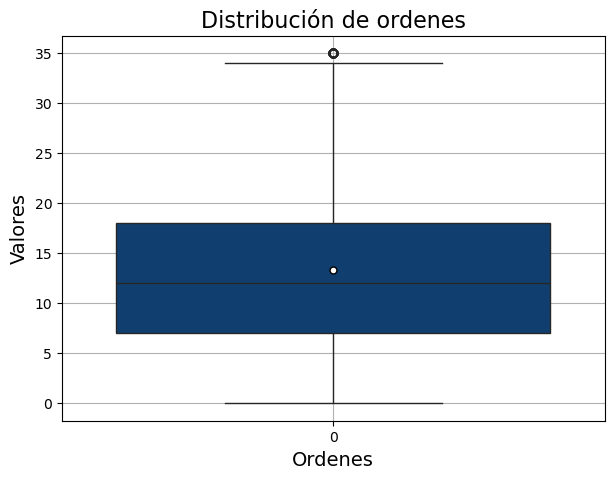

In [12]:
#Gráfico de caja y bigotes al retirar los outliners
fig = plt.figure(figsize =(7, 5))

sns.boxplot(df_filtered.values, showmeans=True, meanprops={'marker':'o',
                                                     'markerfacecolor':'white',
                                                     'markersize':'5',
                                                     'markeredgecolor':'black'},
           palette='ocean_r'
           )

plt.title('Distribución de ordenes', fontsize=16)
plt.xlabel('Ordenes', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.grid(True) 

plt.show()

### Remuestreo

Se utilizó la función *resample()* para remuestrear los datos de ordenes para que pasaran de intervalos de 10 minutos a intervalos de una hora utilizando la función *sum()* para contemplar el total de ordenes realizadas en dicho intervalo de tiempo.

<Axes: xlabel='datetime'>

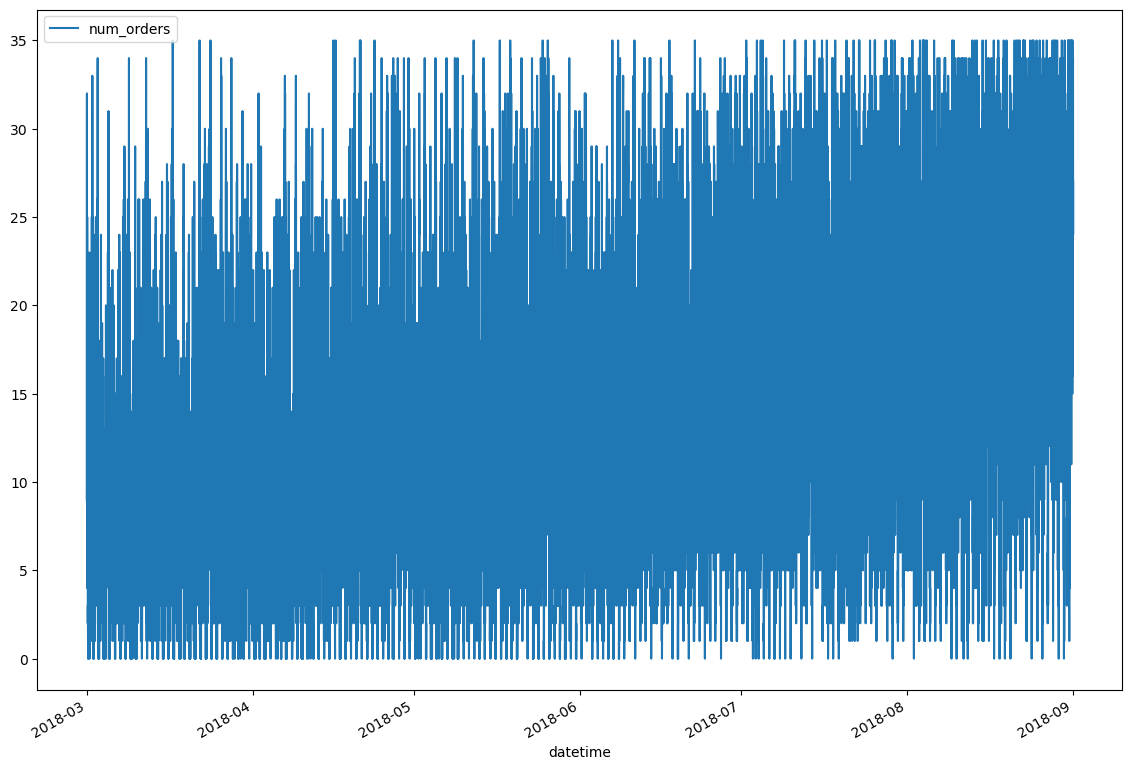

In [13]:
#Serie temporal inicial del número de ordenes

df_filtered.plot(figsize=(14,10))

'H' is deprecated and will be removed in a future version, please use 'h' instead.


<Axes: xlabel='datetime'>

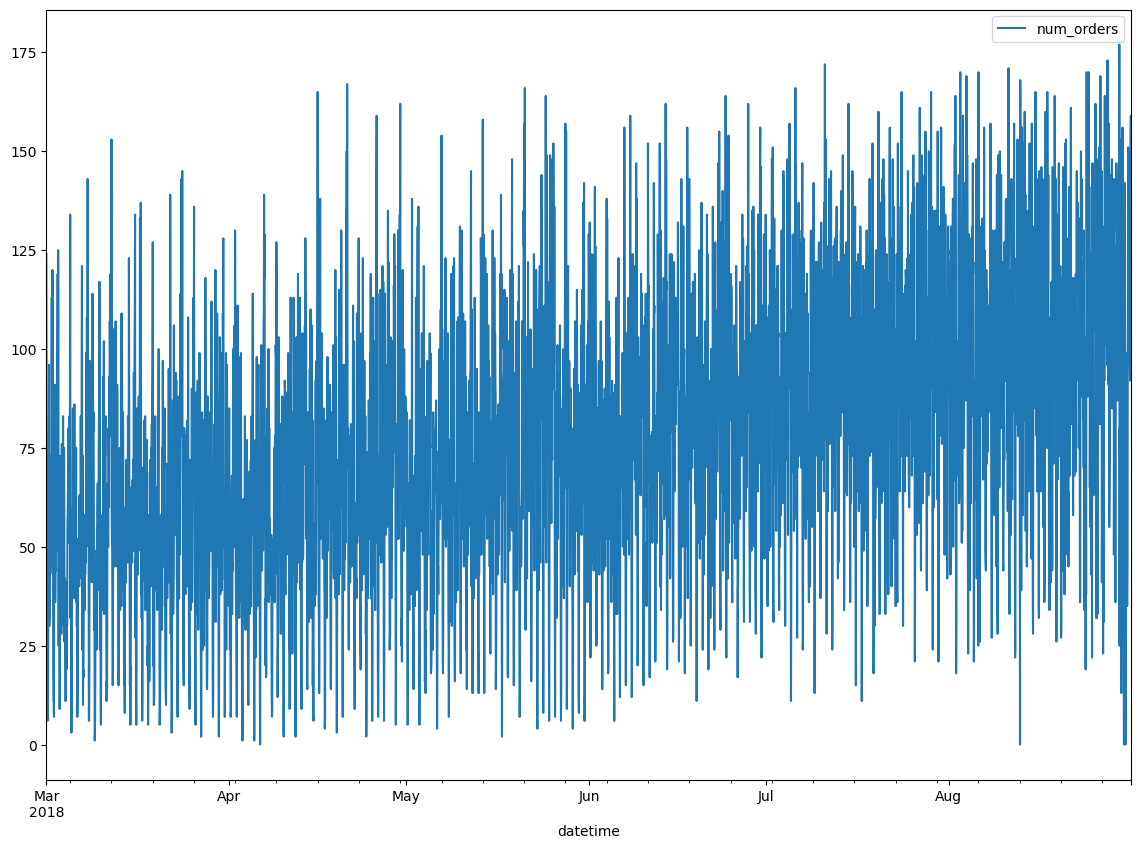

In [14]:
#Remuestreo para que se muestre intervalos por hora en el dataframe

df_filtered = df_filtered.resample('1H').sum()
df_filtered.plot(figsize=(14,10))

### Análisis de tendencias y estacionalidad

Se utilizó el módulo *tsa.seasonal*  de la librería *statsmodels* contiene la función *seasonal_decompose()*. Con dicha función se dividió la serie en tres componentes: tendencia, estacionalidad y residuos

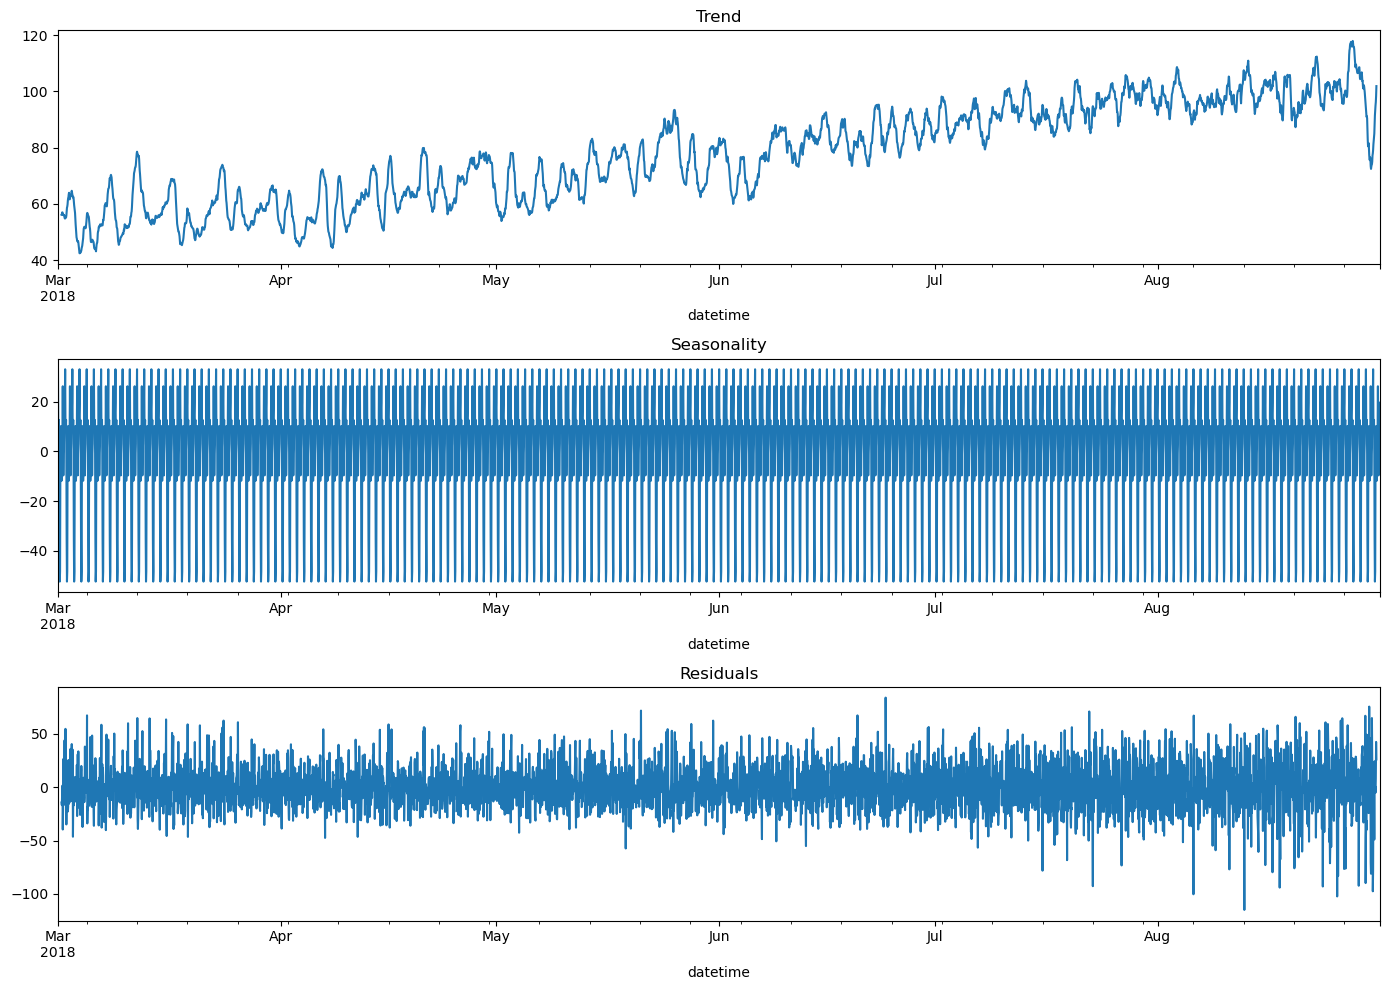

In [15]:
decomposed = seasonal_decompose(df_filtered)

plt.figure(figsize=(14,10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Se observó que existe una tendencia principalmente ascendente en el número de ordenes de taxis conforme transcurren los meses del año oscilando aproximadamente entre 35 y 118 ordenes. La temporalidad muestra una oscilación entre -50 y 40 ordenes aproximadamente que se refieren a las ordenes que son solicitadas de forma repetida cada hora. Finalmente, el último gráfico hace referencia a los residuos que son artefactos computancionales que no requirieron mayor análisis.

### Media y desviación estándar móvil

Utilizando la función *rolling()* se construyó la ventana movil contemplando una ventana de 6 horas para la media aritmética y la desviación estándar, con la finalidad de conocer si la serie temporal es estacionaria.

<Axes: xlabel='datetime'>

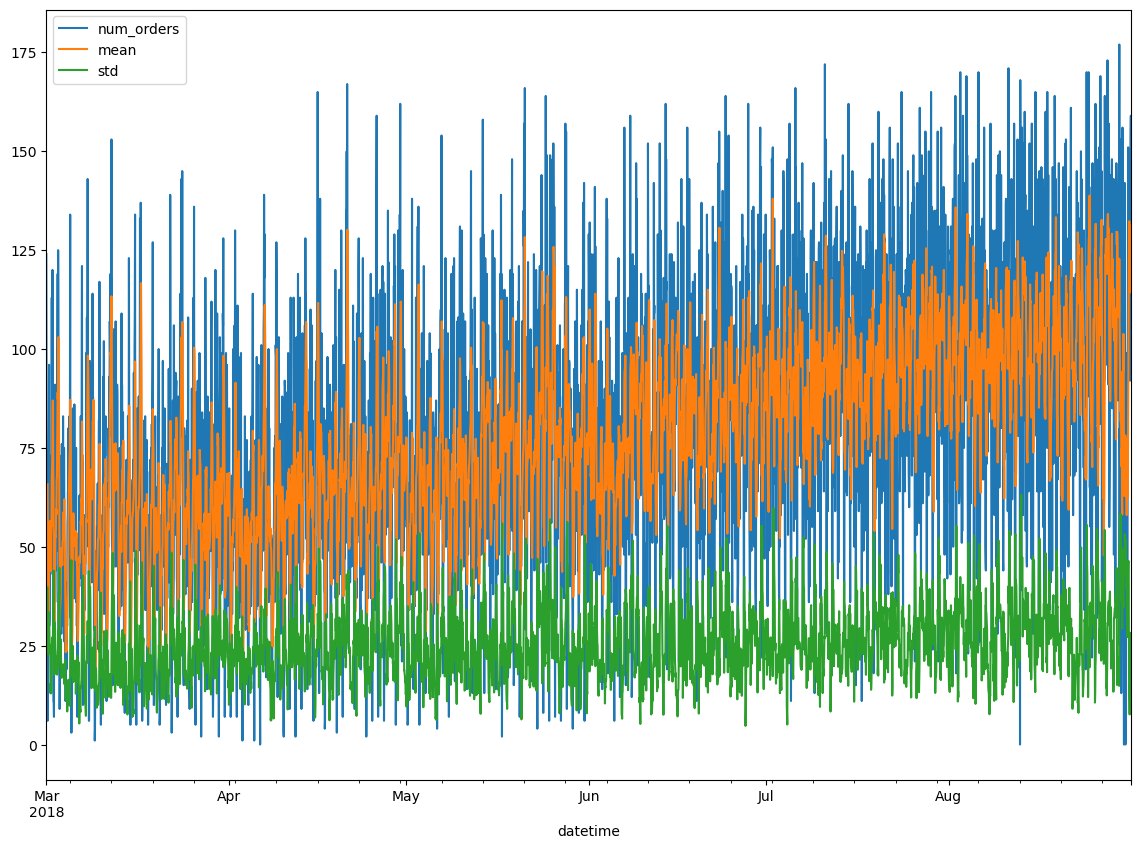

In [16]:
df_filtered['mean'] = df_filtered['num_orders'].rolling(6).mean()
df_filtered['std'] = df_filtered['num_orders'].rolling(6).std()
df_filtered.plot(figsize=(14,10))

Se observo que la media móvil no es estacionaria ya que presenta una tendencia a incrementar conforme transcurre el tiempo, por otra parte la desviación estándar también incrmenta en función del tiempo. Por ello se calculó las diferencias de la serie temporal, buscando obtener una serie temporal estacionaria.

### Cálculo de diferencias de la serie temporal

Se usó el método *.shift()* se usa para encontrar las diferencias de series temporales, utilizando el parámetro *fill_value* con el argumento *0* para rellenar los valores ausentes.

<Axes: xlabel='datetime'>

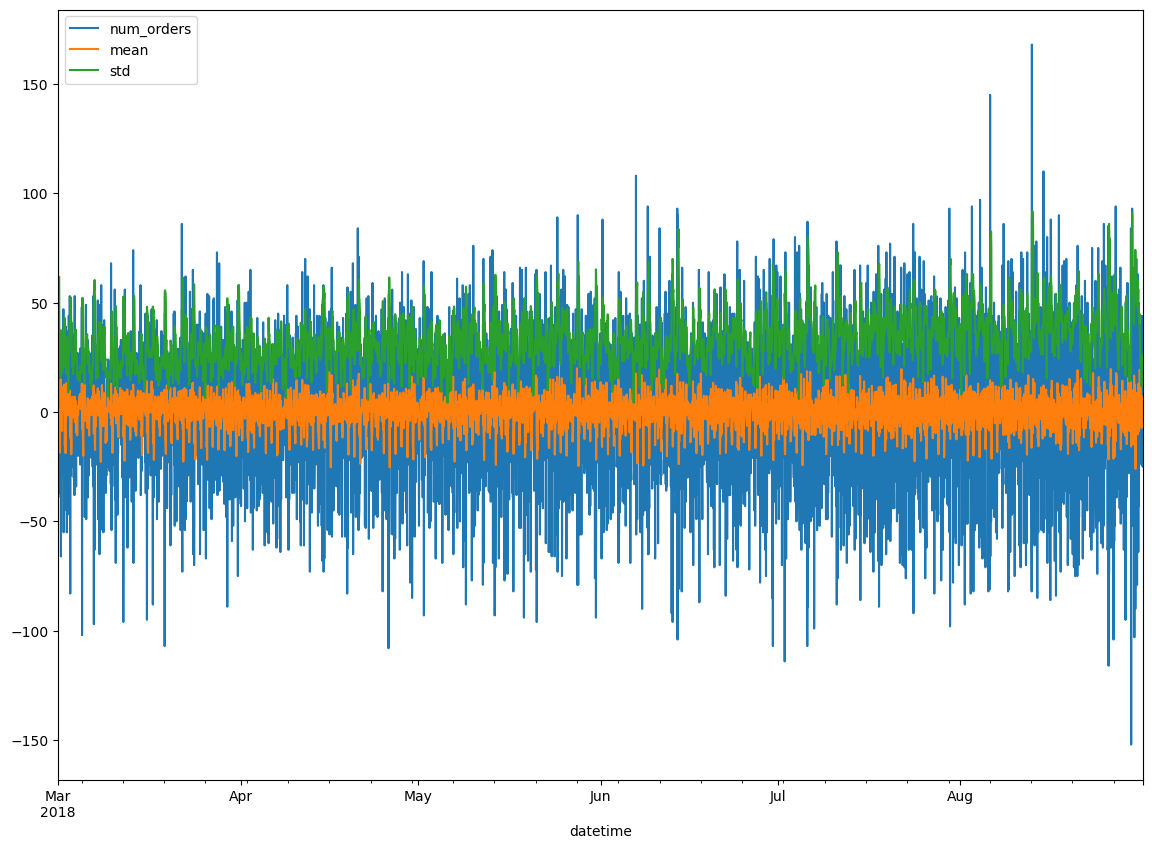

In [17]:
#Cálculo de las diferencias de las series temporales

df_filtered-= df_filtered.shift(fill_value=0)
df_filtered['mean'] = df_filtered['num_orders'].rolling(6).mean()
df_filtered['std'] = df_filtered['num_orders'].rolling(6).std()
df_filtered.plot(figsize=(14,10))

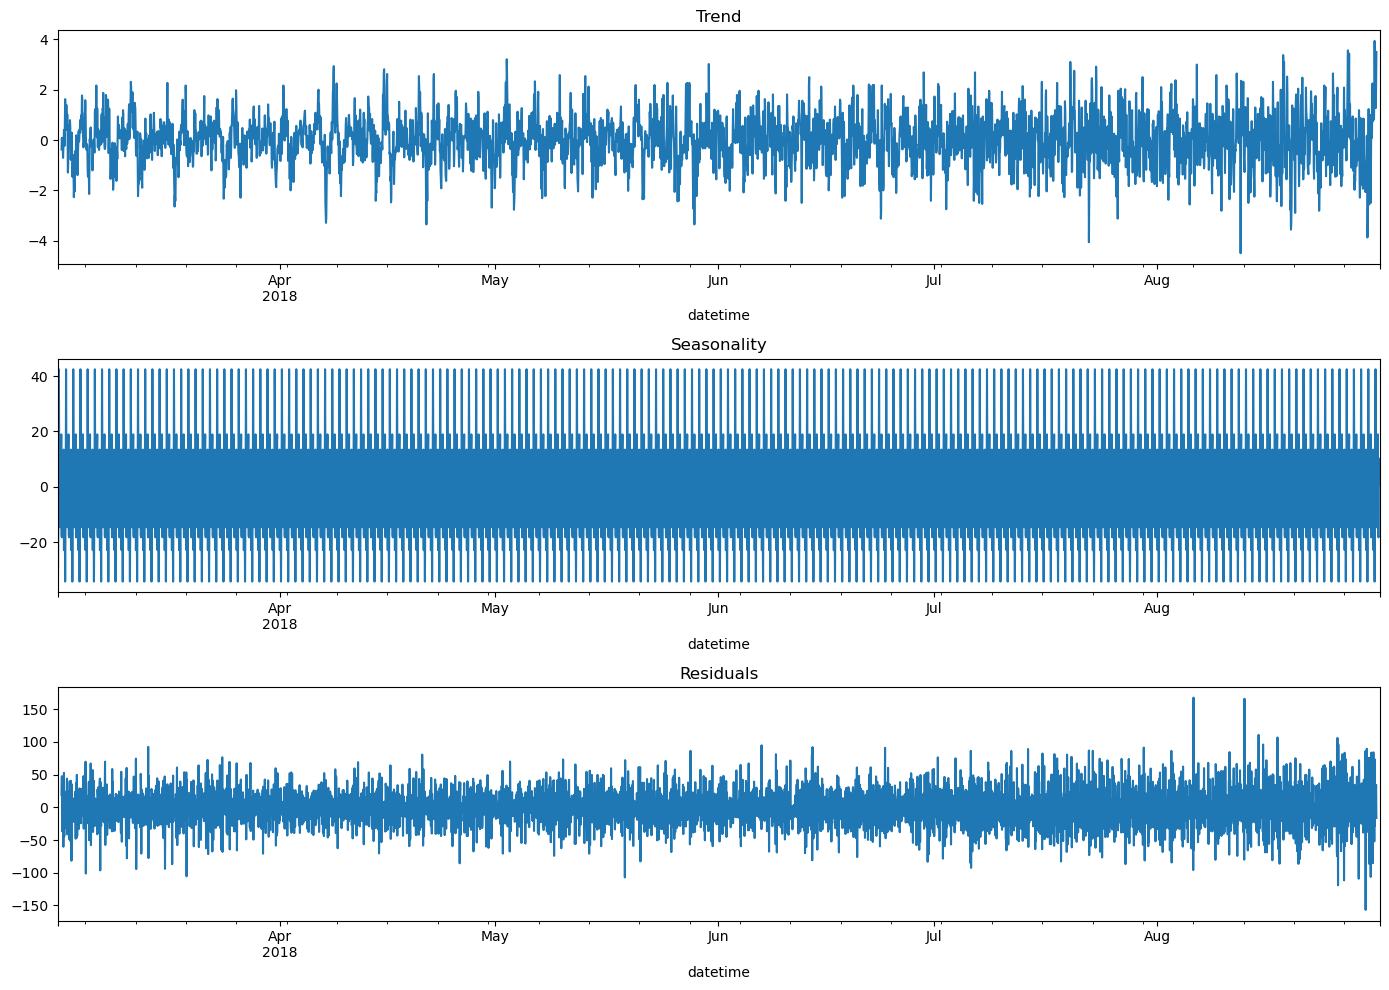

In [18]:
#Comprobación mediante la función descomposed()

df_seasonal_check = df_filtered.copy()
df_seasonal_check.dropna(inplace=True)
df_seasonal_check.drop(['mean', 'std'], axis=1, inplace=True)
decomposed_check = seasonal_decompose(df_seasonal_check)

plt.figure(figsize=(14,10))
plt.subplot(311)

decomposed_check.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed_check.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed_check.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

La serie temporal resultante tuvo un mayor carácter estacionario.

## Formación

### Creación de carácterísticas

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    '''
    Función para crear columnas de carácteristicas que se utilizaran en el entrenamiento de los modelos de ML. Se crean
    cuatro columnas derivadas de los datos de fecha del índice, se crea un valor a definir por los parámetros para las columnas
    lag y finalmente la columna de media y std móvil con el método .shift() para descartar el valor actual.
    '''
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    data['rolling_std'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).std()
    )

In [20]:
#Eliminación de las columnas mean y std
df_filtered.drop(['mean', 'std'], axis=1, inplace=True)

#Aplicación de función make_features
make_features(df_filtered, 4, 6)

#Eliminación de NaN
df_filtered = df_filtered.dropna()

display(df_filtered.head(10))

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean,rolling_std
datetime,,,,,,,,,,,
2018-03-01 06:00:00,6,2018,3,1,3,-37.0,-23.0,-5.0,-14.0,1.000000,61.660360
2018-03-01 07:00:00,3,2018,3,1,3,6.0,-37.0,-23.0,-5.0,-18.666667,17.806366
2018-03-01 08:00:00,19,2018,3,1,3,3.0,6.0,-37.0,-23.0,-11.666667,16.415440
2018-03-01 09:00:00,35,2018,3,1,3,19.0,3.0,6.0,-37.0,-6.166667,20.497967
2018-03-01 10:00:00,-5,2018,3,1,3,35.0,19.0,3.0,6.0,0.500000,26.561250
2018-03-01 11:00:00,32,2018,3,1,3,-5.0,35.0,19.0,3.0,3.500000,24.296090
2018-03-01 12:00:00,-66,2018,3,1,3,32.0,-5.0,35.0,19.0,15.000000,16.309506
2018-03-01 13:00:00,2,2018,3,1,3,-66.0,32.0,-5.0,35.0,3.000000,37.271973
2018-03-01 14:00:00,16,2018,3,1,3,2.0,-66.0,32.0,-5.0,2.833333,37.274209


### Segmentación

Se utilizó el método *train_test_split* con el argumento *False* en *shuffle* para evitar que se mezclaran datos asincrónicos, considerando una segmentación del 80% de los datos para el conjunto de entrenamiento y 10% para validación y 10% para prueba.

In [21]:
train, temp = train_test_split(df_filtered, shuffle= False, test_size=0.8)
valid, test = train_test_split(temp, shuffle= False, test_size=0.5)

#Comprobación de que se respeto la secuencia de los datos en la segmentación
print('Segmento de entrenamiento:\n', train.index.min(), train.index.max())
print('Segmento de validación:\n', valid.index.min(), valid.index.max())
print('Segmento de prueba:\n', test.index.min(), test.index.max())

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Segmento de entrenamiento:
 2018-03-01 06:00:00 2018-04-06 23:00:00
Segmento de validación:
 2018-04-07 00:00:00 2018-06-19 11:00:00
Segmento de prueba:
 2018-06-19 12:00:00 2018-08-31 23:00:00


### Estandarización de características

In [22]:
numeric = ['year', 'month', 'day', 'dayofweek', 'lag_1','lag_2', 'lag_3', 'lag_4', 'rolling_mean', 'rolling_std']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean,rolling_std
datetime,,,,,,,,,,
2018-03-01 06:00:00,0.0,-0.441726,-1.39091,-0.013893,-1.327414,-0.824690,-0.180279,-0.500597,0.137621,3.358191
2018-03-01 07:00:00,0.0,-0.441726,-1.39091,-0.013893,0.210732,-1.325613,-0.824319,-0.178210,-2.650589,-1.006798
2018-03-01 08:00:00,0.0,-0.441726,-1.39091,-0.013893,0.103419,0.212937,-1.325239,-0.822984,-1.658175,-1.145243
2018-03-01 09:00:00,0.0,-0.441726,-1.39091,-0.013893,0.675752,0.105596,0.213301,-1.324475,-0.878422,-0.738890
2018-03-01 10:00:00,0.0,-0.441726,-1.39091,-0.013893,1.248086,0.678080,0.105961,0.215818,0.066734,-0.135384


### Prueba de cordura

In [23]:
class LinearRegression:
    '''
    Creación de clase LinearRegression para crear una regresión lineal que devuelva la media de la columna target, 
    con el proposito de realizar una prueba de corduara de los modelos entrenados.
    '''
    def fit(self, features_train, target_train):
        self.w = np.zeros(features_train.shape[1])
        self.w0 = target_train.mean()
    
    def predict(self, features_valid):
        return features_valid.dot(self.w) + self.w0

sanity_model = LinearRegression()
sanity_model.fit(features_train, target_train)

pred_train = sanity_model.predict(features_train)
pred_valid = sanity_model.predict(features_valid)

print(
    'RMSE para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train)**0.5
)
print(
    'RMSE para el conjunto de validación:', mean_squared_error(target_valid, pred_valid)**0.5
)

display(pred_valid)

RMSE para el conjunto de entrenamiento: 27.9368371192727
RMSE para el conjunto de validación: 31.540420747819798


datetime
2018-04-07 00:00:00    0.126984
2018-04-07 01:00:00    0.126984
2018-04-07 02:00:00    0.126984
2018-04-07 03:00:00    0.126984
2018-04-07 04:00:00    0.126984
                         ...   
2018-06-19 07:00:00    0.126984
2018-06-19 08:00:00    0.126984
2018-06-19 09:00:00    0.126984
2018-06-19 10:00:00    0.126984
2018-06-19 11:00:00    0.126984
Freq: h, Length: 1764, dtype: float64

### Bosque aleatorio de regresión

Se creo un modelo de bosque aleatorio de regresión optimizando los hiperparámetros del modelo para lograr reducir el rmse, cubriendo un intervalo de n_estimators de 10 a 50, en secuencias de 10, y alternando la profunidad de los árboles entre 1 y 10 nodos.

In [24]:
# Valores iniciales de hiperparámetros

best_error = 1000
best_est = 0
best_depth = 0

#Creación de bucle para probar diferentes hiperparámetros del Bosque aleatorio

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_ft = RandomForestRegressor(random_state=54321, n_estimators=est, max_depth=depth)
        model_ft.fit(features_train, target_train)
        predictions_train_train = model_ft.predict(features_train)
        predictions_valid = model_ft.predict(features_valid)
        error = mean_squared_error(target_valid, predictions_valid)**0.5
        print("Validación RECM para los n_estimators de", est, ", depth=", depth, "es", error)
        if error < best_error: # guardamos la configuración del modelo si se logra el error más bajo
            best_error = error
            best_est = est
            best_depth = depth

Validación RECM para los n_estimators de 10 , depth= 1 es 28.796738066433228
Validación RECM para los n_estimators de 10 , depth= 2 es 28.293933938793057
Validación RECM para los n_estimators de 10 , depth= 3 es 28.087834136742977
Validación RECM para los n_estimators de 10 , depth= 4 es 28.208562439278214
Validación RECM para los n_estimators de 10 , depth= 5 es 28.527897048112354
Validación RECM para los n_estimators de 10 , depth= 6 es 28.68263795564806
Validación RECM para los n_estimators de 10 , depth= 7 es 28.97134083498663
Validación RECM para los n_estimators de 10 , depth= 8 es 28.965267117365084
Validación RECM para los n_estimators de 10 , depth= 9 es 29.333789059433222
Validación RECM para los n_estimators de 10 , depth= 10 es 29.32039163143842
Validación RECM para los n_estimators de 20 , depth= 1 es 28.779567158007396
Validación RECM para los n_estimators de 20 , depth= 2 es 28.28380208835704
Validación RECM para los n_estimators de 20 , depth= 3 es 28.040126179150523
Va

In [25]:
#Mostrar la mejor combinación de hiperparámetros

print("RECM del mejor modelo en el conjunto de validación:", best_error.round(5) , "n_estimators:", best_est, "best_depth:", best_depth)

RECM del mejor modelo en el conjunto de validación: 28.00684 n_estimators: 30 best_depth: 3


#### Optimización de hiperparámetros

##### GridSearch()

In [26]:
#Creación del modelo de Bosque Aleatorio simple

rfc = RandomForestRegressor(random_state=54321)
rfc.fit(features_train, target_train)
rfc_pred = rfc.predict(features_valid)
print('El RMSE para un bosque aleatorio simple es:' ,mean_squared_error(target_valid, rfc_pred)**0.5)

El RMSE para un bosque aleatorio simple es: 28.825200825106315


In [27]:
#Definir hiperparámetros a tunear
forest_params = [
    {'max_depth':list(range(1,10)), 'n_estimators':list(range(1,50))}
]

In [28]:
clf = GridSearchCV(rfc, forest_params, cv=9, scoring='neg_mean_squared_error', error_score='raise')
clf.fit(features_train, target_train)

print(f"Mejor valor para max_depth: {clf.best_params_['max_depth']}")
print(f"Mejor valor para n_estimators: {clf.best_params_['n_estimators']}")
print(f"Mejor estimador: {clf.best_estimator_}")
print(f"Mejor puntuación: {clf.best_score_}")

Mejor valor para max_depth: 9
Mejor valor para n_estimators: 49
Mejor estimador: RandomForestRegressor(max_depth=9, n_estimators=49, random_state=54321)
Mejor puntuación: -527.8357510383754


In [29]:
clf_predict = clf.predict(features_valid)
print('El RMSE para un bosque aleatorio con GridSearch() es:', mean_squared_error(target_valid, clf_predict)**0.5)

El RMSE para un bosque aleatorio con GridSearch() es: 28.76001548182565


##### Optuna

In [30]:
class ModelOptimization:
    '''
    Creación de clase para tunear hiperparámetros utilizando Optuna
    '''

    def __init__(self, features_train, features_valid, target_train, target_valid):
        self.features_train = features_train
        self.features_valid = features_valid
        self.target_train = target_train
        self.target_valid = target_valid
    
    def objective(self, trial):
        max_depth = trial.suggest_int('max_depth', 1, 10)
        n_estimators = trial.suggest_int('n_estimators', 1, 50)

        model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=54321)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        error = mean_squared_error(target_valid, predictions_valid)**0.5

        return error

In [31]:
optuna_model = ModelOptimization(features_train, features_valid, target_train, target_valid)

study = optuna.create_study(direction='minimize')

study.optimize(optuna_model.objective, n_trials=2000)

[I 2024-09-13 11:34:39,184] A new study created in memory with name: no-name-2e0079cb-9fc3-4623-900f-fc508019ad88
[I 2024-09-13 11:34:39,315] Trial 0 finished with value: 28.857015852281293 and parameters: {'max_depth': 9, 'n_estimators': 36}. Best is trial 0 with value: 28.857015852281293.
[I 2024-09-13 11:34:39,381] Trial 1 finished with value: 28.09563242252556 and parameters: {'max_depth': 4, 'n_estimators': 31}. Best is trial 1 with value: 28.09563242252556.
[I 2024-09-13 11:34:39,502] Trial 2 finished with value: 28.37907225534964 and parameters: {'max_depth': 6, 'n_estimators': 47}. Best is trial 1 with value: 28.09563242252556.
[I 2024-09-13 11:34:39,577] Trial 3 finished with value: 28.739455280495008 and parameters: {'max_depth': 9, 'n_estimators': 18}. Best is trial 1 with value: 28.09563242252556.
[I 2024-09-13 11:34:39,634] Trial 4 finished with value: 28.624321282361265 and parameters: {'max_depth': 8, 'n_estimators': 15}. Best is trial 1 with value: 28.09563242252556.
[I

In [32]:
print(f'Mejores parametros: {study.best_params}')
print(f'Mejor RCME: {study.best_value}')

Mejores parametros: {'max_depth': 3, 'n_estimators': 31}
Mejor RCME: 28.003781650692254


In [33]:
optuna.visualization.plot_optimization_history(study)

### Potenciación de gradiente

#### CatBoost

Se creo y entreno un modelo de potenciación de gradiente con la libreria de CatBoost. Se procedió a optimizar los parámetros del modelo de forma manual y posteriormente se utilizaron los frameworks Optuna y Shap. Se realizó un análisis comparativo.

##### Optimización manual de hiperparámetros

In [34]:
%%time
model_cat = CatBoostRegressor(learning_rate=.02, depth=7, random_seed=54321, iterations=40000, loss_function='RMSE')
model_cat.fit(features_train, target_train, cat_features= None, verbose= 10000)
preds = model_cat.predict(features_valid)

0:	learn: 27.8180227	total: 150ms	remaining: 1h 39m 51s
10000:	learn: 0.1484004	total: 25.8s	remaining: 1m 17s
20000:	learn: 0.0027654	total: 52.3s	remaining: 52.3s
30000:	learn: 0.0000465	total: 1m 18s	remaining: 26.1s
39999:	learn: 0.0000008	total: 1m 46s	remaining: 0us
CPU times: total: 1min 32s
Wall time: 1min 52s


In [35]:
print(mean_squared_error(target_valid, preds)**0.5)

28.955061947597997


El rmse del modelo de potenciación de gradiente utilizando catboost fue ligeramente menor que el de bosque aleatorio.

##### Optuna Hyperparameters tunning

In [91]:
early_stopping_round = 100 #Early stopping del entrenamiento del modelo si es que no se minimiza el RMSE de forma consecutiva en el entrenamiento

In [92]:
def optuna_catboost(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", .01, .02, step=0.001)
    param['depth'] = trial.suggest_int('depth', 7, 10)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5) #Controla el sobreajuste de las hojas del árbol penalizando valores grandes en las hojas, para ello pasa valores entre 1 y 5.5 en intervalos de 0.5
    param['grow_policy'] = 'Depthwise' #Se completa la expansión del nivel del árbol antes de aumentar su profundidad controlando el sobreajuste
    param['iterations'] = 400000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter' #Criterio de early stopping que hace que la prueba se detenga si el modelo no mejora en el número de iteraciones en od_wait
    param['od_wait'] = 50 #Número de iteraciones consecutivas que se permiten antes de activar el early stopping
    param['random_state'] = 54321
    param['logging_level'] = 'Silent' #Para evitar que a cada iteración se muestren mensajes en el log
    
    cat_regressor = CatBoostRegressor(**param)

    cat_regressor.fit(features_train.copy(), target_train.copy(),
                  eval_set =[(features_valid.copy(), target_valid.copy())],
                  early_stopping_rounds = early_stopping_round)
    loss = mean_squared_error(target_valid, cat_regressor.predict(features_valid.copy()))
    return loss

In [93]:
%%time
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(optuna_catboost, n_trials=1000, timeout=24000)

[I 2024-09-13 12:44:03,180] A new study created in memory with name: no-name-93c260e8-c71f-46fd-ab9d-5c52fbcc347e
[I 2024-09-13 12:44:05,714] Trial 0 finished with value: 794.7081487128656 and parameters: {'learning_rate': 0.015, 'depth': 7, 'l2_leaf_reg': 4.5}. Best is trial 0 with value: 794.7081487128656.
[I 2024-09-13 12:44:09,954] Trial 1 finished with value: 811.9353174660243 and parameters: {'learning_rate': 0.018000000000000002, 'depth': 9, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 794.7081487128656.
[I 2024-09-13 12:44:12,746] Trial 2 finished with value: 791.4711495034857 and parameters: {'learning_rate': 0.014, 'depth': 7, 'l2_leaf_reg': 5.5}. Best is trial 2 with value: 791.4711495034857.
[I 2024-09-13 12:44:15,981] Trial 3 finished with value: 791.4711495034857 and parameters: {'learning_rate': 0.014, 'depth': 7, 'l2_leaf_reg': 5.5}. Best is trial 2 with value: 791.4711495034857.
[I 2024-09-13 12:44:35,364] Trial 4 finished with value: 825.5461951039856 and paramete

CPU times: total: 1h 35min 22s
Wall time: 1h 10min 20s


In [94]:
print(f'Mejores parámetros: {study_cat.best_params}')
print(f'Mejor RMSE: {(study_cat.best_value)**0.5}')

Mejores parámetros: {'learning_rate': 0.013000000000000001, 'depth': 7, 'l2_leaf_reg': 3.0}
Mejor RMSE: 27.98970752014983


In [95]:
optuna.visualization.plot_optimization_history(study_cat)

In [99]:
%%time

# Creación de regresor optimizado

optimized_regressor = CatBoostRegressor(learning_rate=study_cat.best_params['learning_rate'],
                                        depth=study_cat.best_params['depth'],
                                        l2_leaf_reg=study_cat.best_params['l2_leaf_reg'],
                                        grow_policy='Depthwise',
                                        iterations=400000,
                                        use_best_model=True,
                                        eval_metric='RMSE',
                                        od_type='iter',
                                        od_wait=50,
                                        random_state=54321,
                                        logging_level='Silent')
optimized_regressor.fit(features_train.copy(), target_train.copy(),
                        eval_set=[(features_valid.copy(), target_valid.copy())],
                        early_stopping_rounds=early_stopping_round)
pred_train = optimized_regressor.predict(features_train.copy())
pred_valid = optimized_regressor.predict(features_valid.copy())

CPU times: total: 1.81 s
Wall time: 1.9 s


In [100]:
print(
    'RMSE para el conjunto de entrenamiento:', mean_squared_error(target_train, pred_train)**0.5
)
print(
    'RMSE para el conjunto de validación:', mean_squared_error(target_valid, pred_valid)**0.5
)

RMSE para el conjunto de entrenamiento: 16.271799180154517
RMSE para el conjunto de validación: 27.98970752014983


## Prueba

In [101]:
pred_test = optimized_regressor.predict(features_test)

print(
    'RMSE para el conjunto de prueba:', mean_squared_error(target_test, pred_test)**0.5
)

RMSE para el conjunto de prueba: 34.75493907600593


In [102]:
target_test.describe()

count    1764.000000
mean        0.029478
std        37.203892
min      -152.000000
25%       -24.000000
50%         1.000000
75%        25.000000
max       168.000000
Name: num_orders, dtype: float64

## Conclusion

El rmse del modelo de bosque aleatorio con el conjunto de datos de prueba fue de 35.65 al predecir el número de ordenes de servicio de taxi siendo menor al umbral solicitado de 48 a partir de una serie temporal de datos en un excenario con horizonte de una hora.

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [x]  Los datos han sido descargados y preparados.
- [x]  Se ha realizado el paso 2: los datos han sido analizados
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x]  Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48